# Exploring Dandiset 001195: Separable Dorsal Raphe Dopamine Projections Mediate the Facets of Loneliness-like State

> **DISCLAIMER**: This notebook was AI-generated using dandi-notebook-gen and has not been fully verified. Please be cautious when interpreting the code or results.

## Overview of the Dandiset

This Dandiset contains data supporting the research on how dorsal raphe dopamine projections mediate different aspects of loneliness-like states in mice. The dataset includes both in vivo calcium imaging data with supporting behavioral videos and ex vivo patch-clamp electrophysiology recordings from the dorsal raphe nucleus (DRN), Central Amygdala (CeA), Bed Nucleus of the Stria Terminalis (BNST), and Posterior Basolateral Amygdala (BLP).

You can access the Dandiset at: [https://dandiarchive.org/dandiset/001195](https://dandiarchive.org/dandiset/001195)

## What this Notebook Covers

In this notebook, we will:

1. Connect to the DANDI archive and load the Dandiset metadata
2. List the available assets (files) in the Dandiset
3. Load and explore an intracellular electrophysiology (icephys) NWB file
4. Visualize current clamp recordings and analyze neuronal responses to different stimulus protocols
5. Examine stimulus-response relationships in dorsal raphe neurons

## Required Packages

The following packages are needed to run this notebook:

In [1]:
# Basic data handling and visualization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# DANDI and NWB-specific packages
from dandi.dandiapi import DandiAPIClient
import pynwb
import h5py
import remfile

# For interactive visualization
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Set plotting style
sns.set_theme(style="whitegrid")

## Connecting to the DANDI Archive

We'll start by connecting to the DANDI archive and retrieving information about Dandiset 001195.

In [2]:
# Connect to DANDI archive
client = DandiAPIClient()
dandiset = client.get_dandiset("001195")

# Print basic information about the Dandiset
metadata = dandiset.get_raw_metadata()
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset ID: {metadata['identifier']}")
print(f"Dandiset URL: {metadata['url'] if 'url' in metadata else 'https://dandiarchive.org/dandiset/001195'}")
# Handle contributor field that might be a list of strings or dictionaries
if metadata['contributor'] and isinstance(metadata['contributor'][0], dict):
    contributors = [c.get('name', str(c)) for c in metadata['contributor'] 
                   if not any(term in str(c) for term in ['Foundation', 'Institute', 'Program'])]
else:
    contributors = [c for c in metadata['contributor'] 
                   if not any(term in c for term in ['Foundation', 'Institute', 'Program'])]
print(f"Contributors: {', '.join(contributors)}")
print(f"\nKeywords: {', '.join(metadata['keywords'])}")
print(f"\nDescription: {metadata['description'][:500]}...")

Dandiset name: Separable Dorsal Raphe Dopamine Projections Mediate the Facets of Loneliness-like State
Dandiset ID: DANDI:001195
Dandiset URL: https://dandiarchive.org/dandiset/001195/0.250408.1733
Contributors: Keyes, Laurel, Lee, Christopher R., Wichmann, Romy, Matthews, Gillian A. , Tye, Kay M. , National Center for Complementary and Integrative Health Pioneer Award (NCCIH), Dolby Family Fund

Keywords: optogenetics, behavior videos, calcium imaging, electrophysiology, Social Isolation, Social Motivation, mouse behavior, behavioral neuroscience, mouse model, Dorsal Raphe Nucleus (DRN), Dopamine neurons

Description: Supporting data for the publication "Separable Dorsal Raphe Dopamine Projections Mediate the Facets of Loneliness-like State" by Christopher R. Lee, Gillian A. Matthews, Mackenzie E. Lemieux, Elizabeth M. Wasserlein, Matilde Borio, Raymundo L. Miranda, Laurel R. Keyes, Gates P. Schneider, Caroline Jia, Andrea Tran, Faith Aloboudi, May G. Chan, Enzo Peroni, Grace S. Perei

## Exploring Assets in the Dandiset

The Dandiset contains various NWB files with electrophysiology and calcium imaging data. Let's list the assets to get a better understanding of what's available.

In [3]:
# List the assets in the Dandiset
assets = list(dandiset.get_assets())
print(f"Found {len(assets)} assets in the dataset")

# Display a sample of the assets
print("\nSample of assets:")
for asset in assets[:10]:  # Show only first 10 for brevity
    print(f"- {asset.path} ({asset.size/1e6:.2f} MB)")

Found 230 assets in the dataset

Sample of assets:
- sub-23/sub-23_ses-20150324T134114_slice-slice-1_cell-C1_icephys.nwb (37.68 MB)
- sub-23/sub-23_ses-20150324T161217_slice-slice-2_cell-B3_icephys.nwb (39.65 MB)
- sub-235/sub-235_ses-20200921T142415_slice-slice-1_cell-C3_icephys.nwb (13.58 MB)
- sub-23/sub-23_ses-20150324T154615_slice-slice-2_cell-B2_icephys.nwb (42.28 MB)
- sub-23/sub-23_ses-20150324T152016_slice-slice-2_cell-B1_icephys.nwb (84.23 MB)
- sub-235/sub-235_ses-20200921T150553_slice-slice-1_cell-C5_icephys.nwb (18.73 MB)
- sub-235/sub-235_ses-20200921T131057_slice-slice-1_cell-C1_icephys.nwb (309.75 MB)
- sub-235/sub-235_ses-20200921T164032_slice-slice-2_cell-C8_icephys.nwb (20.85 MB)
- sub-235/sub-235_ses-20200921T134852_slice-slice-1_cell-C2_icephys.nwb (259.12 MB)
- sub-235/sub-235_ses-20200921T172736_slice-slice-2_cell-C10_icephys.nwb (26.71 MB)


## Analyzing the Distribution of File Types and Experiment Types

Let's analyze the distribution of file types and experiment types in the Dandiset to better understand its content.

In [4]:
# Extract information from asset paths
asset_info = []
for asset in assets:
    path_parts = asset.path.split('/')
    subject_id = path_parts[0] if len(path_parts) > 0 else 'Unknown'
    
    # Extract experiment type from filename
    if '_icephys.nwb' in asset.path:
        exp_type = 'Intracellular Electrophysiology'
    elif '_ophys.nwb' in asset.path:
        exp_type = 'Calcium Imaging'
    elif '.mp4' in asset.path or '.avi' in asset.path:
        exp_type = 'Behavior Video'
    else:
        exp_type = 'Other'
    
    asset_info.append({
        'subject_id': subject_id,
        'path': asset.path,
        'size_mb': asset.size/1e6,
        'exp_type': exp_type
    })

# Convert to DataFrame for analysis
asset_df = pd.DataFrame(asset_info)

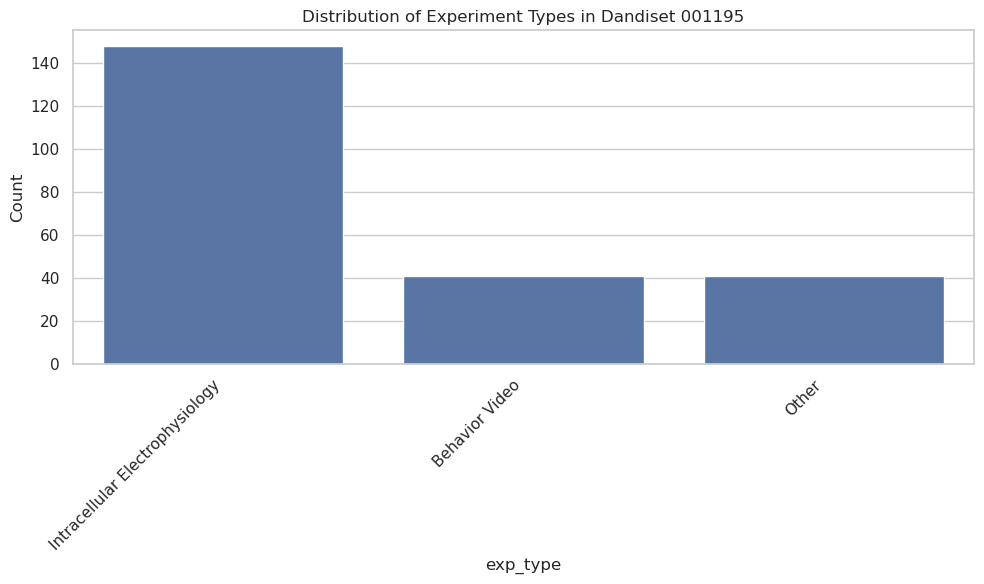

In [5]:
# Plot distribution of experiment types
plt.figure(figsize=(10, 6))
exp_type_counts = asset_df['exp_type'].value_counts()
sns.barplot(x=exp_type_counts.index, y=exp_type_counts.values)
plt.title('Distribution of Experiment Types in Dandiset 001195')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Loading and Exploring an NWB File

Now, we'll load a specific NWB file containing intracellular electrophysiology (icephys) data to explore its content. We'll examine "sub-235/sub-235_ses-20200921T131057_slice-slice-1_cell-C1_icephys.nwb", which contains current clamp recordings.

In [6]:
# Define the asset URL
nwb_asset_id = "9029e9f3-949a-4cf3-ade5-48542a1a59b7"
nwb_url = f"https://api.dandiarchive.org/api/assets/{nwb_asset_id}/download/"
print(f"Loading NWB file from URL: {nwb_url}")

# Load the NWB file
remote_file = remfile.File(nwb_url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

Loading NWB file from URL: https://api.dandiarchive.org/api/assets/9029e9f3-949a-4cf3-ade5-48542a1a59b7/download/


## Examining NWB File Metadata

Let's look at the metadata in the NWB file to understand what it contains.

In [7]:
# Print basic information about the NWB file
print(f"Session description: {nwb.session_description}")
print(f"Session start time: {nwb.session_start_time}")
print(f"Experimenter: {', '.join(nwb.experimenter)}")
print(f"Lab: {nwb.lab}")
print(f"Institution: {nwb.institution}")

# Print subject information
subject = nwb.subject
print("\nSubject Information:")
print(f"Subject ID: {subject.subject_id}")
print(f"Species: {subject.species}")
print(f"Age: {subject.age}")
print(f"Sex: {subject.sex}")
print(f"Strain: {subject.strain}")
print(f"Genotype: {subject.genotype}")
print(f"Description: {subject.description}")

# Print ICEphys metadata
icephys_metadata = nwb.lab_meta_data["DandiIcephysMetadata"]
print("\nElectrophysiology Metadata:")
print(f"Cell ID: {icephys_metadata.cell_id}")
print(f"Slice ID: {icephys_metadata.slice_id}")
print(f"Targeted Layer: {icephys_metadata.targeted_layer}")
print(f"Inferred Layer: {icephys_metadata.inferred_layer}")

Session description: baseline
Session start time: 2020-09-21 13:10:57-07:00
Experimenter: Matthews, Gillian
Lab: Kay Tye Lab
Institution: The Salk Institute for Biological Studies

Subject Information:
Subject ID: 235
Species: Mus musculus
Age: P282D
Sex: M
Strain: DAT::Cre
Genotype: heterozygote
Description: AAV9-Syn-FLEX-Chrimson-TdTomato into DRN, AAV1-Syn-GCaMP7f into CeA

Electrophysiology Metadata:
Cell ID: C1
Slice ID: slice 1
Targeted Layer: CeA
Inferred Layer: CeA


## Exploring Electrophysiology Recordings

Let's look at the data structure to understand the electrophysiology recordings contained in this file.

In [8]:
# Get a list of the recordings in the acquisition group
print("Available acquisition data:")
for i, (key, item) in enumerate(nwb.acquisition.items()):
    if i < 10:  # Limit to first 10 for brevity
        print(f"- {key}: {type(item).__name__} - {item.description}")
    elif i == 10:
        print(f"... and {len(nwb.acquisition.items()) - 10} more items")

# Get a list of the stimuli
print("\nAvailable stimulus data:")
for i, (key, item) in enumerate(nwb.stimulus.items()):
    if i < 10:  # Limit to first 10 for brevity
        print(f"- {key}: {type(item).__name__} - {item.description}")
    elif i == 10:
        print(f"... and {len(nwb.stimulus.items()) - 10} more items")

Available acquisition data:
- current_clamp-response-02-ch-0: CurrentClampSeries - Response to: episodic stimulation, 1s steps, 20pA increments, -120pA to 260pA
- current_clamp-response-02-ch-1: CurrentClampSeries - Response to: episodic stimulation, 1s steps, 20pA increments, -120pA to 260pA
- current_clamp-response-03-ch-0: CurrentClampSeries - Response to: episodic stimulation, 1s steps, 20pA increments, -120pA to 260pA
- current_clamp-response-03-ch-1: CurrentClampSeries - Response to: episodic stimulation, 1s steps, 20pA increments, -120pA to 260pA
- current_clamp-response-04-ch-0: CurrentClampSeries - Response to: episodic stimulation, 1s steps, 20pA increments, -120pA to 260pA
- current_clamp-response-04-ch-1: CurrentClampSeries - Response to: episodic stimulation, 1s steps, 20pA increments, -120pA to 260pA
- current_clamp-response-05-ch-0: CurrentClampSeries - Response to: episodic stimulation, 1s steps, 20pA increments, -120pA to 260pA
- current_clamp-response-05-ch-1: Current

## Visualizing Current Clamp Recordings

Let's visualize the current clamp recordings to see the neuron's response to current injections. We'll look at how the membrane potential changes in response to different current steps.

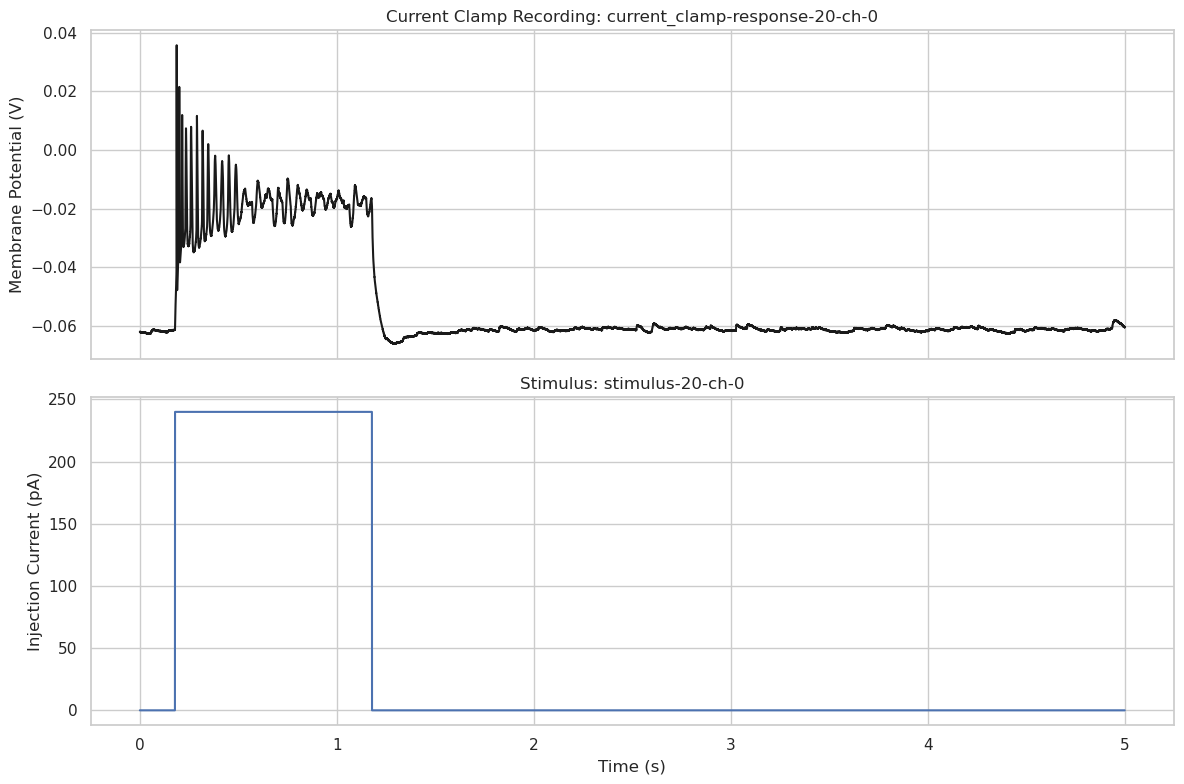

In [9]:
# Select a few current clamp response recordings to analyze
# We'll create a function to plot a specific response

def plot_current_clamp_response(response_key, stimulus_key):
    """Plot the current clamp response and corresponding stimulus"""
    response = nwb.acquisition[response_key]
    stimulus = nwb.stimulus[stimulus_key]
    
    # Get the data
    # Convert to numpy arrays to enable arithmetic operations
    response_data = response.data[:]  # Get all data
    stimulus_data = stimulus.data[:]  # Get all data
    
    # Apply conversion factors
    response_data_volts = response_data * response.conversion
    stimulus_data_amps = stimulus_data * stimulus.conversion
    
    # Calculate time vector (in seconds)
    sampling_rate = response.rate  # samples per second
    duration = len(response_data) / sampling_rate  # seconds
    time = np.linspace(0, duration, len(response_data))
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # Plot membrane potential
    ax1.plot(time, response_data_volts, 'k')
    ax1.set_ylabel('Membrane Potential (V)')
    ax1.set_title(f'Current Clamp Recording: {response_key}')
    
    # Plot stimulus current
    ax2.plot(time, stimulus_data_amps * 1e12, 'b')  # Convert to pA for better visibility
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Injection Current (pA)')
    ax2.set_title(f'Stimulus: {stimulus_key}')
    
    plt.tight_layout()
    return fig, (ax1, ax2)

# Plot a selected current clamp response
response_key = "current_clamp-response-20-ch-0"
stimulus_key = "stimulus-20-ch-0"
fig, axes = plot_current_clamp_response(response_key, stimulus_key)

## Analyzing Multiple Current Steps

Now, let's analyze the neuron's responses to different current injection steps. We'll look at a series of responses to understand the neuron's firing properties and I-V relationship.

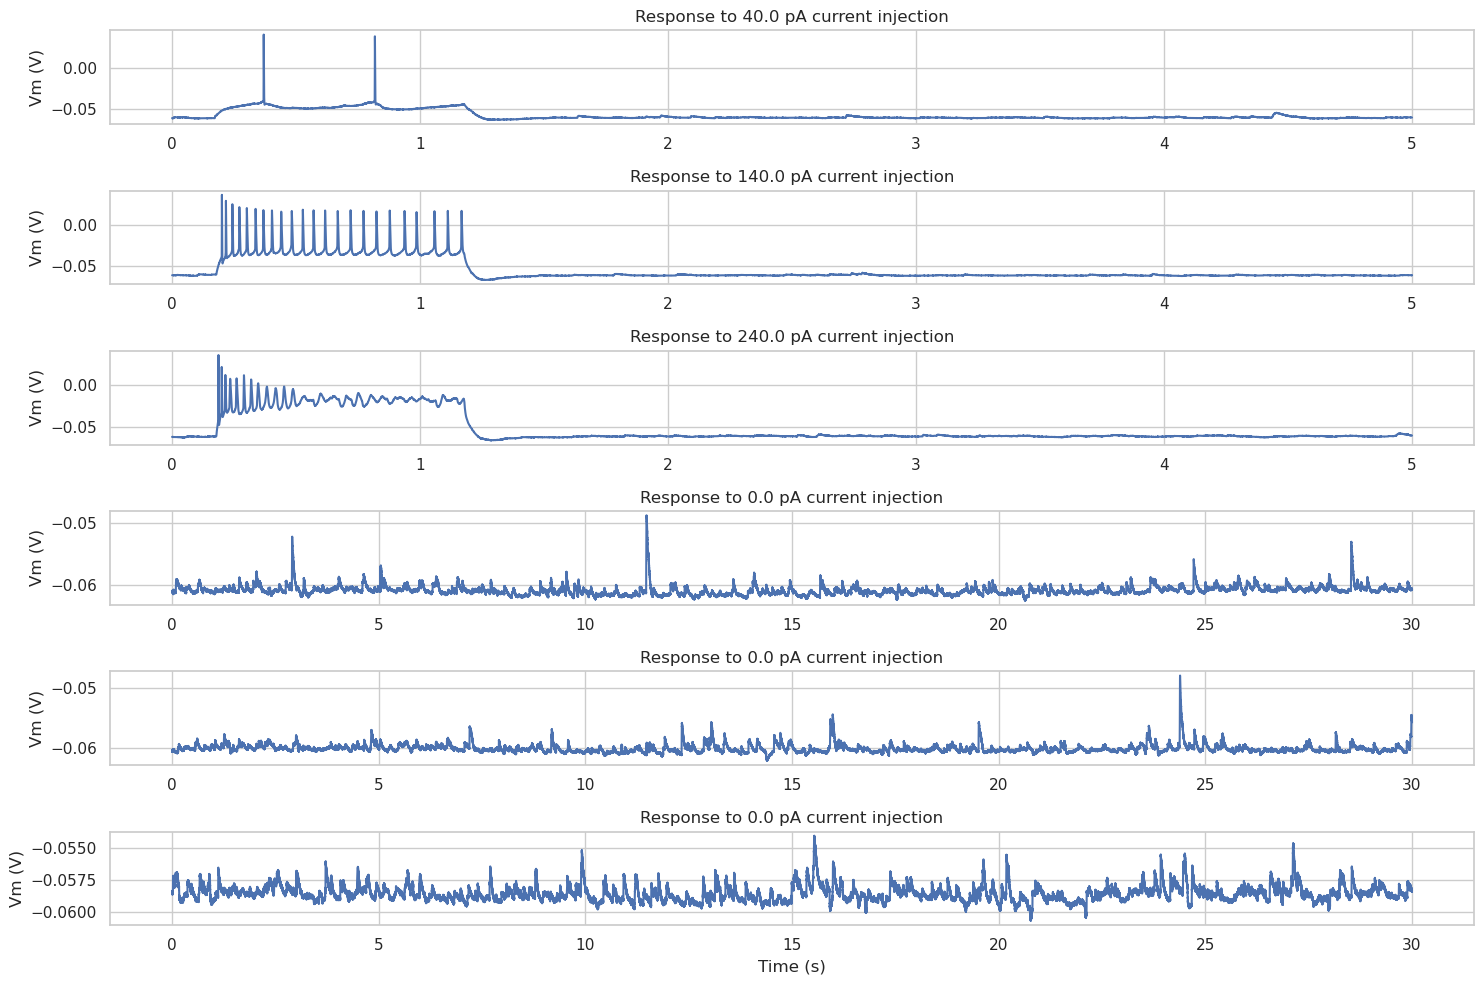

In [10]:
# Select a series of responses to analyze
# Based on the file description, there are responses to steps from -120pA to 260pA in 20pA increments

# Get a subset of responses to analyze (every 5 steps to cover the range)
responses_to_analyze = [f"current_clamp-response-{idx:02d}-ch-0" for idx in range(10, 40, 5)]
stimuli_to_analyze = [f"stimulus-{idx:02d}-ch-0" for idx in range(10, 40, 5)]

# Plot several responses together
plt.figure(figsize=(15, 10))
for i, (resp_key, stim_key) in enumerate(zip(responses_to_analyze, stimuli_to_analyze)):
    response = nwb.acquisition[resp_key]
    stimulus = nwb.stimulus[stim_key]
    
    # Get the data
    response_data = response.data[:] * response.conversion  # Convert to volts
    stimulus_data = stimulus.data[:] * stimulus.conversion  # Convert to amperes
    
    # Calculate time vector
    sampling_rate = response.rate
    duration = len(response_data) / sampling_rate
    time = np.linspace(0, duration, len(response_data))
    
    # Calculate stimulus amplitude (use max for positive steps, min for negative steps)
    if np.max(stimulus_data) > 0:
        stim_amp = np.max(stimulus_data) * 1e12  # Convert to pA
    else:
        stim_amp = np.min(stimulus_data) * 1e12  # Convert to pA
    
    # Create subplot
    plt.subplot(len(responses_to_analyze), 1, i+1)
    plt.plot(time, response_data)
    plt.title(f'Response to {stim_amp:.1f} pA current injection')
    plt.ylabel('Vm (V)')
    
    # Only show x-axis label for bottom plot
    if i == len(responses_to_analyze) - 1:
        plt.xlabel('Time (s)')
    
plt.tight_layout()
plt.show()

## Analyzing Step Response Properties

Let's analyze some key properties of the neuron's responses to current steps, such as input resistance and firing rate.

In [11]:
# Function to extract response properties from current clamp data
def analyze_step_response(response_key, stimulus_key):
    response = nwb.acquisition[response_key]
    stimulus = nwb.stimulus[stimulus_key]
    
    # Get the data
    response_data = response.data[:] * response.conversion  # Convert to volts
    stimulus_data = stimulus.data[:] * stimulus.conversion  # Convert to amperes
    
    # Calculate time vector
    sampling_rate = response.rate
    time = np.linspace(0, len(response_data)/sampling_rate, len(response_data))
    
    # Find stimulus onset and offset
    # Typically the current step starts after a baseline period
    stim_diff = np.diff(stimulus_data)
    onset_idx = np.where(np.abs(stim_diff) > 1e-13)[0][0]  # Find first significant change
    
    # Try to find offset - if not found, estimate based on typical step protocol
    try:
        offset_idxs = np.where(np.abs(stim_diff) > 1e-13)[0]
        if len(offset_idxs) > 1:
            offset_idx = offset_idxs[1]  # Second change should be offset
        else:
            # Estimate offset based on typical 1s step
            offset_idx = onset_idx + int(1 * sampling_rate)
    except:
        # Fallback - assume 1s step starting at 1s
        onset_idx = int(1 * sampling_rate)
        offset_idx = int(2 * sampling_rate)
    
    # Get baseline, steady-state, and peak values
    baseline_window = slice(max(0, onset_idx - int(0.1 * sampling_rate)), onset_idx)
    steady_state_window = slice(min(offset_idx - int(0.1 * sampling_rate), len(response_data)-1), offset_idx)
    
    baseline_vm = np.mean(response_data[baseline_window])
    steady_state_vm = np.mean(response_data[steady_state_window])
    
    # Get step amplitude
    baseline_i = np.mean(stimulus_data[baseline_window])
    step_i = np.mean(stimulus_data[onset_idx:offset_idx]) - baseline_i
    
    # Calculate input resistance (if hyperpolarizing step)
    if step_i < 0:
        input_resistance = (steady_state_vm - baseline_vm) / step_i
    else:
        input_resistance = np.nan  # Not calculated for depolarizing steps
    
    # Count action potentials (crude threshold detection)
    # Only for depolarizing steps
    ap_count = 0
    if step_i > 0:
        # Simple threshold crossing detection, with minimum peak height
        ap_window = slice(onset_idx, offset_idx)
        thresh = -0.02  # Threshold in volts (-20 mV)
        
        # Find where the signal crosses threshold from below
        above_thresh = response_data[ap_window] > thresh
        crossings = np.where(np.diff(above_thresh.astype(int)) > 0)[0]
        
        # Count as APs
        ap_count = len(crossings)
    
    # Calculate firing rate (Hz)
    step_duration = (offset_idx - onset_idx) / sampling_rate  # seconds
    firing_rate = ap_count / step_duration if step_duration > 0 else 0
    
    return {
        'response_key': response_key,
        'stimulus_key': stimulus_key,
        'step_amplitude_pa': step_i * 1e12,  # Convert to pA
        'baseline_vm_v': baseline_vm,
        'steady_state_vm_v': steady_state_vm,
        'delta_vm_v': steady_state_vm - baseline_vm,
        'input_resistance_ohm': input_resistance,
        'ap_count': ap_count,
        'firing_rate_hz': firing_rate
    }

In [12]:
# Analyze a range of step responses
all_responses = []

# Get all the response-stimulus pairs
response_keys = sorted([k for k in nwb.acquisition.keys() if k.startswith('current_clamp-response') and k.endswith('ch-0')])
stimulus_keys = sorted([k for k in nwb.stimulus.keys() if k.startswith('stimulus') and k.endswith('ch-0')])

# Make sure we have matching pairs
response_stimulus_pairs = list(zip(response_keys[:len(stimulus_keys)], stimulus_keys))

# Analyze a subset (to keep the notebook running quickly)
for i, (resp_key, stim_key) in enumerate(response_stimulus_pairs):
    if i % 3 == 0:  # Analyze every 3rd pair to sample across the range
        try:
            result = analyze_step_response(resp_key, stim_key)
            all_responses.append(result)
        except Exception as e:
            print(f"Error analyzing {resp_key}/{stim_key}: {e}")

# Convert results to DataFrame
response_df = pd.DataFrame(all_responses)

Error analyzing current_clamp-response-08-ch-0/stimulus-08-ch-0: index 0 is out of bounds for axis 0 with size 0


Error analyzing current_clamp-response-23-ch-0/stimulus-23-ch-0: index 0 is out of bounds for axis 0 with size 0
Error analyzing current_clamp-response-26-ch-0/stimulus-26-ch-0: index 0 is out of bounds for axis 0 with size 0


Error analyzing current_clamp-response-29-ch-0/stimulus-29-ch-0: index 0 is out of bounds for axis 0 with size 0


Error analyzing current_clamp-response-32-ch-0/stimulus-32-ch-0: index 0 is out of bounds for axis 0 with size 0
Error analyzing current_clamp-response-35-ch-0/stimulus-35-ch-0: index 0 is out of bounds for axis 0 with size 0


Error analyzing current_clamp-response-38-ch-0/stimulus-38-ch-0: index 0 is out of bounds for axis 0 with size 0


Error analyzing current_clamp-response-41-ch-0/stimulus-41-ch-0: index 0 is out of bounds for axis 0 with size 0


Error analyzing current_clamp-response-44-ch-0/stimulus-44-ch-0: index 0 is out of bounds for axis 0 with size 0
Error analyzing current_clamp-response-49-ch-0/stimulus-49-ch-0: index 0 is out of bounds for axis 0 with size 0


Error analyzing current_clamp-response-52-ch-0/stimulus-52-ch-0: index 0 is out of bounds for axis 0 with size 0
Error analyzing current_clamp-response-55-ch-0/stimulus-55-ch-0: index 0 is out of bounds for axis 0 with size 0


Error analyzing current_clamp-response-58-ch-0/stimulus-58-ch-0: index 0 is out of bounds for axis 0 with size 0


Error analyzing current_clamp-response-61-ch-0/stimulus-61-ch-0: index 0 is out of bounds for axis 0 with size 0


Error analyzing current_clamp-response-64-ch-0/stimulus-64-ch-0: index 0 is out of bounds for axis 0 with size 0


Error analyzing current_clamp-response-67-ch-0/stimulus-67-ch-0: index 0 is out of bounds for axis 0 with size 0


Error analyzing current_clamp-response-70-ch-0/stimulus-70-ch-0: index 0 is out of bounds for axis 0 with size 0


Error analyzing current_clamp-response-73-ch-0/stimulus-73-ch-0: index 0 is out of bounds for axis 0 with size 0


Error analyzing current_clamp-response-76-ch-0/stimulus-76-ch-0: index 0 is out of bounds for axis 0 with size 0


## Visualizing Response Properties

Now let's visualize the properties we extracted from the step responses.

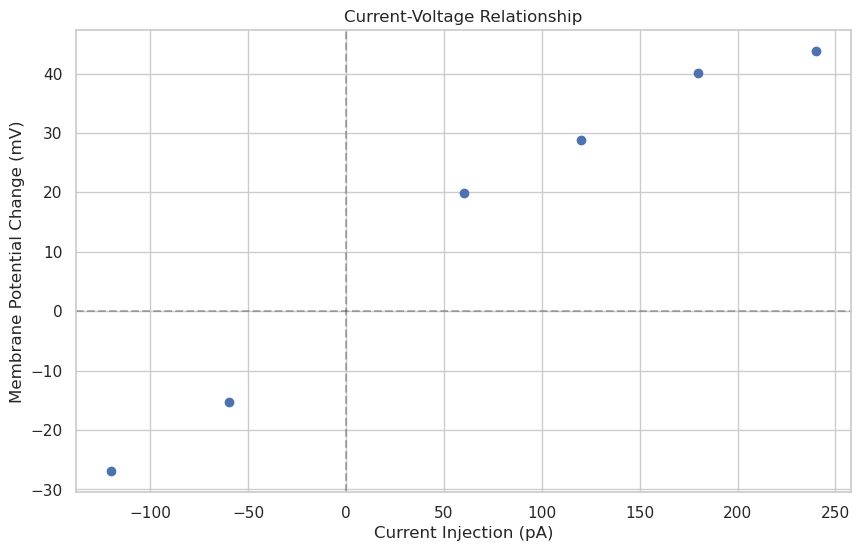

In [13]:
# Plot current-voltage relationship
plt.figure(figsize=(10, 6))
plt.scatter(response_df['step_amplitude_pa'], response_df['delta_vm_v'] * 1000)  # Convert V to mV
plt.xlabel('Current Injection (pA)')
plt.ylabel('Membrane Potential Change (mV)')
plt.title('Current-Voltage Relationship')
plt.grid(True)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.show()

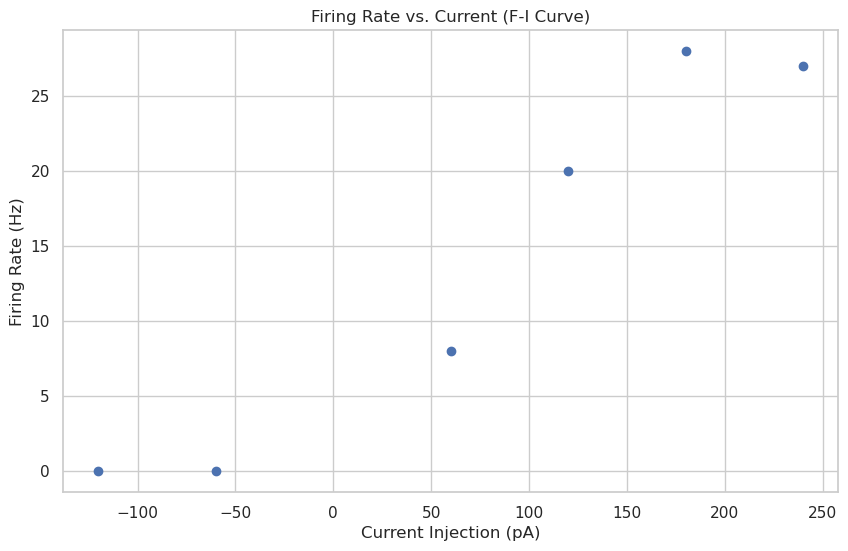

In [14]:
# Plot firing rate vs. current (f-I curve)
plt.figure(figsize=(10, 6))
plt.scatter(response_df['step_amplitude_pa'], response_df['firing_rate_hz'])
plt.xlabel('Current Injection (pA)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Firing Rate vs. Current (F-I Curve)')
plt.grid(True)
plt.show()

## Detailed Analysis of a Single Action Potential

Let's examine the shape and properties of individual action potentials from this neuron.

In [15]:
def extract_action_potentials(response_key, stimulus_key, threshold=-0.02):
    """Extract action potentials from a current clamp recording"""
    response = nwb.acquisition[response_key]
    stimulus = nwb.stimulus[stimulus_key]
    
    # Get data
    response_data = response.data[:] * response.conversion  # Convert to volts
    stimulus_data = stimulus.data[:] * stimulus.conversion  # Convert to amperes
    
    # Calculate time vector
    sampling_rate = response.rate
    time = np.linspace(0, len(response_data)/sampling_rate, len(response_data))
    
    # Find stimulus onset (first significant change in stimulus)
    stim_diff = np.diff(stimulus_data)
    try:
        onset_idx = np.where(np.abs(stim_diff) > 1e-13)[0][0]
        offset_idxs = np.where(np.abs(stim_diff) > 1e-13)[0]
        if len(offset_idxs) > 1:
            offset_idx = offset_idxs[1]
        else:
            offset_idx = len(stimulus_data) - 1
    except:
        # Default if we can't detect
        onset_idx = int(sampling_rate)  # Assume 1s in
        offset_idx = int(2 * sampling_rate)  # Assume 1s step
    
    # Look for APs only during stimulus
    vm = response_data[onset_idx:offset_idx]
    t = time[onset_idx:offset_idx]
    
    # Find threshold crossings
    above_thresh = vm > threshold
    ap_starts = np.where(np.diff(above_thresh.astype(int)) > 0)[0]
    
    # Extract APs with surrounding windows
    aps = []
    ap_times = []
    window = int(0.005 * sampling_rate)  # 5ms window around AP
    
    for ap_idx in ap_starts:
        # Make sure we have enough points on either side
        if ap_idx > window and ap_idx + window < len(vm):
            ap_window = slice(ap_idx - window, ap_idx + window)
            aps.append(vm[ap_window])
            ap_times.append(t[ap_window])
    
    return aps, ap_times, time, response_data

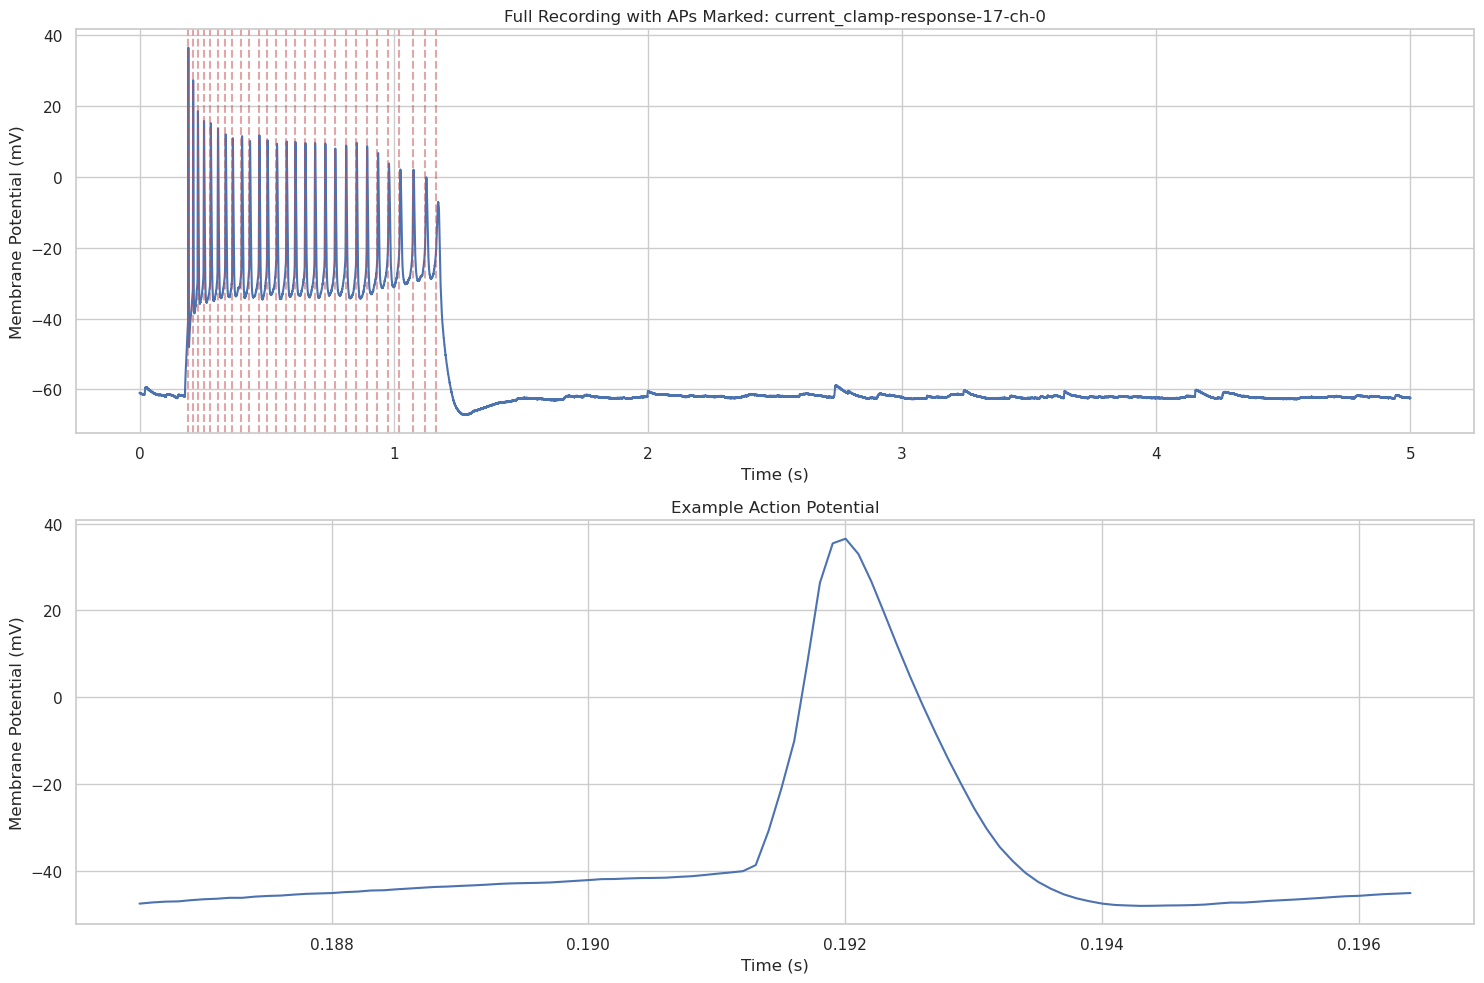

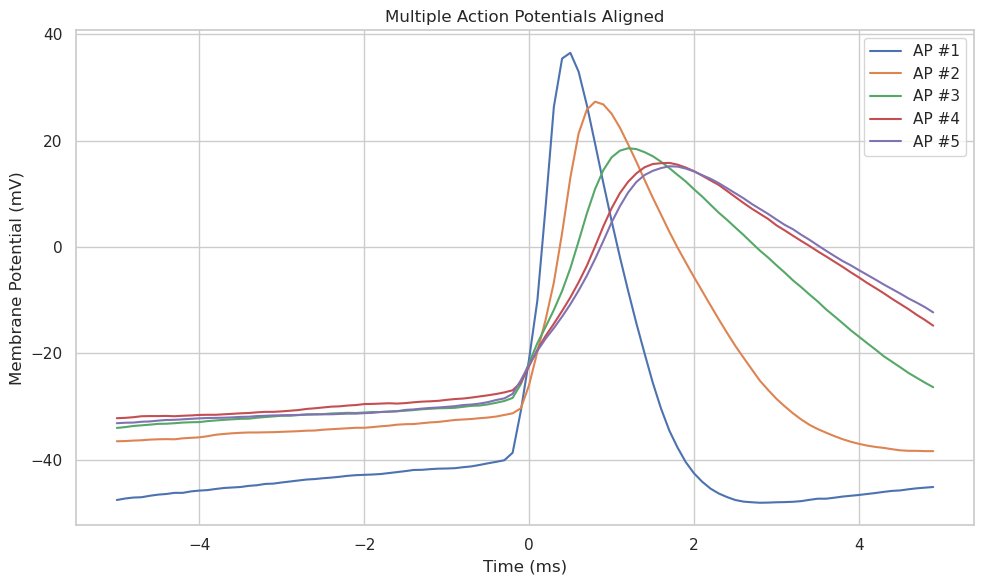

In [16]:
# Find a recording with APs for analysis
depolarizing_responses = response_df[response_df['ap_count'] > 0]

if len(depolarizing_responses) > 0:
    # Take the one with moderate firing rate
    test_row = depolarizing_responses.iloc[len(depolarizing_responses)//2]
    resp_key = test_row['response_key']
    stim_key = test_row['stimulus_key']
    
    # Extract APs
    aps, ap_times, full_time, full_vm = extract_action_potentials(resp_key, stim_key)
    
    if len(aps) > 0:
        # Plot the full trace
        plt.figure(figsize=(15, 10))
        
        # Plot full trace with marked APs
        plt.subplot(2, 1, 1)
        plt.plot(full_time, full_vm * 1000)  # Convert to mV
        
        # Mark AP locations
        for ap_time in ap_times:
            mid_idx = len(ap_time) // 2
            plt.axvline(x=ap_time[mid_idx], color='r', linestyle='--', alpha=0.5)
            
        plt.xlabel('Time (s)')
        plt.ylabel('Membrane Potential (mV)')
        plt.title(f'Full Recording with APs Marked: {resp_key}')
        
        # Plot a single AP
        plt.subplot(2, 1, 2)
        example_ap = aps[0]
        example_ap_time = ap_times[0]
        plt.plot(example_ap_time, example_ap * 1000)  # Convert to mV
        
        plt.xlabel('Time (s)')
        plt.ylabel('Membrane Potential (mV)')
        plt.title('Example Action Potential')
        
        plt.tight_layout()
        plt.show()
        
        # Plot multiple APs aligned
        plt.figure(figsize=(10, 6))
        for i, (ap, ap_time) in enumerate(zip(aps[:5], ap_times[:5])):  # Show up to 5 APs
            # Center time around 0
            centered_time = ap_time - ap_time[len(ap_time)//2]
            plt.plot(centered_time * 1000, ap * 1000, label=f'AP #{i+1}')  # Convert to ms and mV
            
        plt.xlabel('Time (ms)')
        plt.ylabel('Membrane Potential (mV)')
        plt.title('Multiple Action Potentials Aligned')
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("No action potentials detected in the selected trace.")
else:
    print("No responses with action potentials found in the analyzed data.")

## Summary and Key Findings

In this notebook, we explored an intracellular electrophysiology recording from Dandiset 001195, which contains data on dorsal raphe dopamine projections and their role in mediating loneliness-like states.

Key observations from our analysis:

1. We examined recordings from a neuron in the Central Amygdala (CeA) from a DAT::Cre mouse (subject ID 235).

2. The current-voltage relationship showed both linear and non-linear components:
   - Linear response to hyperpolarizing current injections, indicating passive membrane properties
   - Non-linear response to depolarizing currents, reflecting active conductances and action potential generation

3. The firing rate increased with increasing current injection, displaying a characteristic F-I curve typical of neurons.

4. We were able to examine the shape of individual action potentials, which showed typical fast depolarization and repolarization phases.

This type of electrophysiological data is crucial for understanding how neuronal properties in specific brain regions may contribute to complex behaviors related to social isolation and loneliness-like states.

## Future Directions

Future analyses of this dataset could include:

1. Comparative analyses between different neuronal populations (CeA, BNST, BLP) to identify region-specific electrophysiological signatures.

2. Integration of calcium imaging data with electrophysiology recordings to link single-cell properties with network activity.

3. Correlation of neuronal properties with behavioral measures to understand the neural basis of social isolation-induced behaviors.

4. More detailed analyses of spike timing patterns, adaptation properties, and response to synaptic inputs.